### Description of test task

Intorduction

In this assessment, you are working within a Greenplum database. Your task is to design and create
tables to store information about customers, products, sales transactions, and shipping details.
After creating the tables, you need to write a SQL query to perform a complex analysis of the sales
data, including calculating the moving average of sales over a specified time period.

Table Creation Requirements

Customers Table: Create a table named "customers" with columns for customer ID, customer
name, email address, country, and any other relevant information.
Products Table: Create a table named "products" with columns for product ID, product name,
price, category, and any other relevant information.

Sales Transactions Table: Create a table named "sales_transactions" with columns for transaction
ID, customer ID (foreign key referencing the customers table), product ID (foreign key referencing
the products table), purchase date, quantity purchased, and any other relevant information.
Shipping Details Table: Create a table named "shipping_details" with columns for transaction ID
(foreign key referencing the sales_transactions table), shipping date, shipping address, city,
country, and any other relevant information.

Ensure that tables are created in an optimized manner, utilizing data distribution and appropriate
data types and constraints for each column. Establish proper relationships between the tables
using foreign key constraints.

SQL Query Task
Write a SQL query to perform the following analysis:
• Calculate the total sales amount and the total number of transactions for each month.
• Calculate the 3-month moving average of sales amount for each month. The moving
average should be calculated based on the sales data from the previous 3 months
(including the current month).

Submission
Please provide the SQL scripts to create the required tables and the SQL query for the analysis task
along with any additional comments or explanations regarding your table design choices.
Format of the file is up to your preference.

----

https://github.com/SaygafarovT/de_assessment


The repository can also be divided into dev/stage/prod branches if needed.

#### Description of my task and idea

In this task, it was only required to create DDL and SQL queries without using dataframes and to focus solely on their logic. However, I decided to take a broader approach. The idea came to me to turn this task into a hypothetical case requiring Data Engineer skills, while staying within the scope of the original assignment.

Let’s imagine that in some CRM system or another database, denormalized data about transactions, customers, products, and product delivery details are collected in a single table. Our goal is to build an architecture in our analytical database, Greenplum, that allows us to perform analytics on these transactions. Additionally, we need to account for the possibility of integrating similar data sources in the future, even if their transaction IDs might overlap (due to originating from different databases).

For this task, I performed the following steps:

1) Set up a local Greenplum database using a Docker container.
2) Generated hypothetical data for building an ETL process.
3) Wrote DDL queries and designed schemas and tables for the data.
4) Connected to the database using psycopg2.
5) Created tables and loaded the data into them.
6) Wrote SQL queries to retrieve analytical results.
7) Exported the results into dataframes.
8) Visualized the results.

A brief guide on how to locally run a Docker container to verify my work and code:

1) Install Docker.
2) Use the following image: https://hub.docker.com/r/datagrip/greenplum.
3) Run the following command in the terminal: docker pull datagrip/greenplum.
4) Start the container with this command: docker run --name greenplum-container -d -p 5432:5432 datagrip/greenplum:6.8.
5) After that, Docker will initialize the database and create it with the default credentials:

Host: localhost
Port: 5432
Database name: testdb
User: tester
Password: pivotal

If the credentials differ, you may need to check the Docker logs for confirmation.

#### Importing python libraries

In [1]:
### Loading the necessary libraries for our work (some may need to be installed via pip install if they are not already available on your system)
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta
import psycopg2
from psycopg2.extras import execute_values
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# localhost credentials of greenplum db
credentials = {
    "host": "localhost",
    "port": "5432",
    "dbname": "testdb",
    "user": "tester",
    "password": "pivotal"
}

Для генераци данных используется библеотека faker и random

Генерируем следующую таблицу

transaction_id - Unique transaction identifier  
purchase_date - Purchase date  
transaction_status - Transaction status  
customer_id - Customer identifier  
customer_name - Customer name  
customer_email - Customer email address  
customer_country - Customer country  
customer_city - Customer city  
customer_phone - Customer phone number  
customer_birthday - Customer birth date  
customer_address - Customer address  
product_id - Product identifier  
product_name - Product name  
product_category - Product category  
product_price - Product price  
quantity_purchased - Quantity purchased  
currency - Currency  
shipping_address - Shipping address  
shipping_city - Shipping city  
shipping_country - Shipping country  


In this case, I considered the idea that only the statuses of transactions change, while prices, product data, and customer data remain unchanged. This pipeline could also be expanded to allow updates to other parameters (but not all), though that would require extending the architecture. Since this is a test task and such functionality was not part of the requirements, I chose to keep it simple.

For instance, if the price of a product changes, I would add a Slowly Changing Dimension Type 2 (SCD2) to store the history of price changes. This would ensure accurate calculation of total_amount and other potential metrics. Depending on the date in the final data mart, the appropriate price would be used.

The architecture is based on the well-known star schema model.



#### 1. Generating hypothetical data

In [3]:
import random
from datetime import datetime, timedelta
from faker import Faker
import pandas as pd

# Initializing Faker with the 'ru_RU' locale
fake = Faker('ru_RU')
Faker.seed(0)

# Creating a dictionary with products, names, product categories, and prices
products = [
    {"id": 1, "name": "Book A", "category": "Books", "price": 4.99},
    {"id": 2, "name": "Book B", "category": "Books", "price": 5.49},
    {"id": 3, "name": "Microwave", "category": "Kitchen", "price": 25.00},
    {"id": 4, "name": "T-shirt", "category": "Clothing", "price": 8.50},
    {"id": 5, "name": "Washing Machine", "category": "Home Appliance", "price": 100.00},
]

# Creating a dictionary with countries and their cities
countries = ['Russia', 'Kazakhstan', 'Belarus', 'Uzbekistan', 'Georgia', 'Kyrgyzstan']
cities = {
    'Russia': ['Moscow', 'Saint Petersburg', 'Novosibirsk', 'Yekaterinburg', 'Nizhny Novgorod'],
    'Kazakhstan': ['Almaty', 'Astana', 'Shymkent', 'Karaganda', 'Aktobe'],
    'Belarus': ['Minsk', 'Gomel', 'Mogilev', 'Vitebsk', 'Brest'],
    'Uzbekistan': ['Tashkent', 'Samarkand', 'Bukhara', 'Andijan', 'Namangan'],
    'Georgia': ['Tbilisi', 'Batumi', 'Kutaisi', 'Zugdidi', 'Rustavi'],
    'Kyrgyzstan': ['Bishkek', 'Osh', 'Jalal-Abad', 'Karakol', 'Tokmok']
}

# Set for tracking unique transaction IDs, customer IDs, and product IDs
generated_transaction_ids = set()
generated_customer_ids = set()
generated_product_ids = set()

# Function to generate unique IDs
def generate_unique_id(id_set, range_start, range_end):
    while True:
        new_id = random.randint(range_start, range_end)
        if new_id not in id_set:
            id_set.add(new_id)
            return new_id

# Generating 5000 rows
data = []
for _ in range(5000):
    # Generating unique IDs for each type
    transaction_id = generate_unique_id(generated_transaction_ids, 1000000, 9999999)
    customer_id = generate_unique_id(generated_customer_ids, 100, 50000)
    product = random.choice(products)
    product_id = generate_unique_id(generated_product_ids, 1, 9999)  # Unique product IDs

    transaction_status = random.choice(["Pending", "Shipped", "Delivered"])
    purchase_date = datetime(2024, random.randint(1, 12), random.randint(1, 28))
    purchase_date_str = purchase_date.strftime('%Y-%m-%dT%H:%M:%S')
    customer_name = fake.name()
    customer_email = fake.email()
    customer_country = random.choice(countries)
    customer_city = random.choice(cities[customer_country])
    customer_phone = fake.phone_number()
    customer_birthday = fake.date_of_birth(minimum_age=21, maximum_age=65).strftime('%Y-%m-%d')
    customer_address = fake.address().replace('\n', ' ')
    
    # Product data
    product_name = product["name"]
    product_category = product["category"]
    product_price = product["price"]
    
    # Generating quantity
    quantity = random.randint(1, 10)
    
    # Generating shipping_date
    shipping_date = (purchase_date + timedelta(days=random.randint(1, 5))).strftime('%Y-%m-%dT%H:%M:%S')
    
    # Adding data to the result
    data.append({
        "transaction_id": transaction_id,
        "purchase_date": purchase_date_str,
        "transaction_status": transaction_status,
        "customer_id": customer_id,
        "customer_name": customer_name,
        "customer_email": customer_email,
        "customer_country": customer_country,
        "customer_city": customer_city,
        "customer_phone": customer_phone,
        "customer_birthday": customer_birthday,
        "customer_address": customer_address,
        "product_id": product_id,
        "product_name": product_name,
        "product_category": product_category,
        "product_price": product_price,  # Adding product price
        "quantity_purchased": quantity,
        "currency": "USD",
        "shipping_address": customer_address,
        "shipping_city": customer_city,
        "shipping_country": customer_country,
    })

# Creating dataframe
df = pd.DataFrame(data)

# Saving data to CSV
df.to_csv('transactions_data.csv', index=False)


In [4]:
# checking data
df.head(10)

,transaction_id,purchase_date,transaction_status,customer_id,customer_name,customer_email,customer_country,customer_city,customer_phone,customer_birthday,customer_address,product_id,product_name,product_category,product_price,quantity_purchased,currency,shipping_address,shipping_city,shipping_country
0,3730605,2024-02-23T00:00:00,Delivered,3181,Наина Аскольдовна Осипова,svjatoslav_1992@example.com,Belarus,Gomel,8 (593) 824-21-94,2003-06-11,"г. Бугульма, наб. Дорожников, д. 656 стр. 88, ...",1993,Washing Machine,Home Appliance,100.00,7,USD,"г. Бугульма, наб. Дорожников, д. 656 стр. 88, ...",Gomel,Belarus
1,9264083,2024-05-12T00:00:00,Pending,45296,Власова Агата Юрьевна,marian1983@example.com,Russia,Saint Petersburg,+7 393 328 71 15,1998-05-24,"к. Усть-Илимск, бул. Свободный, д. 9 к. 99, 71...",7094,Washing Machine,Home Appliance,100.00,1,USD,"к. Усть-Илимск, бул. Свободный, д. 9 к. 99, 71...",Saint Petersburg,Russia
2,8085475,2024-12-13T00:00:00,Delivered,40838,Герасимов Евгений Гаврилович,kostinaivanna@example.com,Kyrgyzstan,Karakol,+7 122 018 68 48,1995-07-16,"д. Кырен, пр. 70 лет Октября, д. 259 к. 6/4, 0...",6593,Washing Machine,Home Appliance,100.00,7,USD,"д. Кырен, пр. 70 лет Октября, д. 259 к. 6/4, 0...",Karakol,Kyrgyzstan
3,5281439,2024-09-05T00:00:00,Delivered,44983,Аркадий Бориславович Шаров,krasilnikovefim@example.org,Kazakhstan,Aktobe,88910139916,1963-02-19,"д. Апатиты, алл. Волжская, д. 4/1, 869141",7644,Book B,Books,5.49,6,USD,"д. Апатиты, алл. Волжская, д. 4/1, 869141",Aktobe,Kazakhstan
4,8941227,2024-11-20T00:00:00,Pending,221,Юдин Ладислав Иларионович,ddenisov@example.net,Russia,Yekaterinburg,8 (091) 634-57-92,1990-05-31,"ст. Ершов, наб. Сплавная, д. 397, 769845",2352,T-shirt,Clothing,8.50,6,USD,"ст. Ершов, наб. Сплавная, д. 397, 769845",Yekaterinburg,Russia
5,8308349,2024-07-24T00:00:00,Shipped,48912,Ипатий Витальевич Шилов,ribakovaanzhelika@example.com,Kyrgyzstan,Tokmok,+7 842 375 9459,2001-08-17,"с. Псков, ул. Молодежная, д. 35 стр. 83, 960696",6779,Book B,Books,5.49,7,USD,"с. Псков, ул. Молодежная, д. 35 стр. 83, 960696",Tokmok,Kyrgyzstan
6,4395830,2024-09-15T00:00:00,Shipped,30614,Алина Викторовна Третьякова,osipovgleb@example.com,Russia,Novosibirsk,8 (789) 007-5470,1995-06-04,"д. Яшкуль, ш. Мельничное, д. 666, 300891",6827,Book A,Books,4.99,8,USD,"д. Яшкуль, ш. Мельничное, д. 666, 300891",Novosibirsk,Russia
7,5377211,2024-08-01T00:00:00,Shipped,5512,Кошелев Евстафий Ефимьевич,zinaida21@example.com,Georgia,Kutaisi,8 104 714 28 51,1998-04-01,"г. Бавлы, бул. Большевистский, д. 6, 977658",2604,Book A,Books,4.99,2,USD,"г. Бавлы, бул. Большевистский, д. 6, 977658",Kutaisi,Georgia
8,8098753,2024-03-26T00:00:00,Pending,6790,Мельников Фрол Ермолаевич,kudrjavtsevaviktorija@example.com,Belarus,Vitebsk,8 551 590 0422,2003-03-15,"с. Уссурийск, наб. Донская, д. 4/1, 281465",3905,T-shirt,Clothing,8.50,3,USD,"с. Уссурийск, наб. Донская, д. 4/1, 281465",Vitebsk,Belarus
9,6488245,2024-02-25T00:00:00,Pending,43074,Велимир Бориславович Шилов,savvati1988@example.com,Belarus,Vitebsk,+7 717 604 52 29,1975-12-01,"ст. Вендинга, бул. Черноморский, д. 260, 884779",6575,Book A,Books,4.99,1,USD,"ст. Вендинга, бул. Черноморский, д. 260, 884779",Vitebsk,Belarus


#### Creating DDL

In this section, I create a database with three layers:

1) Source – This layer is used to store raw, loaded data.
2) Staging – This layer contains an identical table structure to the source, but here a unique ID is generated for each transaction, and statuses are updated. This approach was chosen to handle cases where transactions from different databases may have duplicate transaction IDs. By generating our own unique transaction IDs, we ensure data integrity.
3) Marts – This layer consists of a fact table for transactions and dimension tables, following the star schema model. This model is the most suitable for building analytical data marts and aligns with the implicit goals of the task.

In [5]:
# Creating ddl for schemas and tables
schema_staging = '''create schema staging;'''
schema_marts = '''create schema marts;'''
schema_source = '''create schema source;'''


create_source_transactions_table = '''
        create table if not exists source.transactions (
            transaction_id bigint,                      -- Unique transaction identifier
            purchase_date timestamp not null,                       -- Purchase date
            transaction_status varchar(255) not null,               -- Transaction_status
            customer_id bigint,                                     -- Customer identifier
            customer_name varchar(255) not null,                    -- Customer name
            customer_email varchar(255) not null,                   -- Customer email address
            customer_country varchar(255) not null,                 -- Customer country
            customer_city varchar(255) not null,                    -- Customer city
            customer_phone varchar(255) not null,                   -- Customer phone number
            customer_birthday date not null,                        -- Customer birth date
            customer_address varchar(255) not null,                 -- Customer address
            product_id bigint not null,                             -- Product identifier
            product_name varchar(255) not null,                     -- Product name
            product_category varchar(255) not null,                 -- Product category
            product_price numeric(10, 2) not null,                  -- Product price
            quantity_purchased int not null,                        -- Quantity purchased
            currency varchar not null,                              -- Currency
            shipping_address varchar(255) not null,                 -- Shipping address
            shipping_city varchar(255) not null,                    -- Shipping city
            shipping_country varchar(255) not null,                 -- Shipping country
            upload_date timestamp default current_timestamp         -- Last update timestamp
        )
        distributed by (transaction_id);                  -- Distribution by the transaction_id column
        create index idx_source_transaction_id on source.transactions(transaction_id); -- creating an index for faster work
'''

create_staging_transactions_table = '''
        create table if not exists staging.transactions (
            id bigserial not null,                      -- Unique transaction identifier
            purchase_date timestamp not null,                       -- Purchase date
            transaction_status varchar(255) not null,               -- Transaction_status
            customer_id bigint,                                     -- Customer identifier
            customer_name varchar(255) not null,                    -- Customer name
            customer_email varchar(255) not null,                   -- Customer email address
            customer_country varchar(255) not null,                 -- Customer country
            customer_city varchar(255) not null,                    -- Customer city
            customer_phone varchar(255) not null,                   -- Customer phone number
            customer_birthday date not null,                        -- Customer birth date
            customer_address varchar(255) not null,                 -- Customer address
            product_id bigint not null,                             -- Product identifier
            product_name varchar(255) not null,                     -- Product name
            product_category varchar(255) not null,                 -- Product category
            product_price numeric(10, 2) not null,                  -- Product price
            quantity_purchased int not null,                        -- Quantity purchased
            currency varchar not null,                              -- Currency
            shipping_address varchar(255) not null,                 -- Shipping address
            shipping_city varchar(255) not null,                    -- Shipping city
            shipping_country varchar(255) not null,                  -- Shipping country
            upload_date timestamp,                                   -- Last update timestamp
            constraint transaction_st_pk primary key (id)
        )
        distributed by (id);                  -- Distribution by the transaction_id column
        create index idx_staging_transaction_id on staging.transactions(id); -- creating an index for faster work
'''
create_products_table = '''
        create table if not exists marts.d_products (
            id bigserial not null,                              -- Product identifier
            name varchar(255) not null,                         -- Product name
            category varchar(255) not null,                     -- Product category
            price numeric(10,2) not null,                       -- Product price
            currency varchar not null,                          -- Currency
            upload_date timestamp,                              -- Last update timestamp
            constraint product_pk primary key (id)              
        )
        distributed by (id);                        -- Distribution by the id column
        create index idx_marts_product_id on marts.d_products(id); -- creating an index for faster work
'''

create_customers_table = '''
        create table if not exists marts.d_customers (
            id bigserial not null,                                 -- Customer identifier
            name varchar(255) not null,                            -- Customer name
            email varchar(255) not null,                           -- Customer email address
            country varchar(255) not null,                         -- Customer country
            city varchar(255) not null,                            -- Customer city
            phone varchar(255) not null,                           -- Customer phone number
            birthday date not null,                                -- Customer birth date
            address varchar(255) not null,                         -- Customer address
            upload_date timestamp,                                 -- Last update timestamp
            constraint customer_pk primary key (id)
        )
        distributed by (id);                  -- Distribution by the id column
        create index idx_marts_customer_id on marts.d_customers(id); -- creating an index for faster work
'''
### Важный момент - В Greenplum внешние ключи не будут принудительно применяться, 
### они принимаются и будут храниться как информация в метаданных, а так как нам нужны foreign key
### нам необходимо разработать проверки и тесты в ETL процессе

create_sales_transactions_table = '''
            create table if not exists marts.f_sales_transactions (
            id bigint primary key,                                              -- Unique transaction identifier
            purchase_date timestamp not null,                       -- Purchase date
            customer_id bigint not null,                            -- Customer identifier
            product_id bigint not null,                             -- Product identifier
            quantity_purchased int not null,                        -- Quantity purchased
            transaction_status varchar(255) not null,               -- Transaction status
            upload_date timestamp,                                  -- Last update timestamp
            constraint fk_st_transaction_id foreign key (id) references staging.transactions (id),
            constraint fk_d_customer_id foreign key (customer_id) references marts.d_customers (id),
            constraint fk_d_product_id foreign key (product_id) references marts.d_products (id)
        )
        distributed by (id);                  -- Distribution by the id column
        create index idx_marts_transaction_id on marts.f_sales_transactions(id); -- creating an index for faster work
'''

create_shipping_details_table = '''
        create table if not exists marts.d_shipping_details (
            id bigint primary key,                         -- Transaction identifier
            address varchar(255) not null,                 -- Shipping address
            city varchar(255) not null,                    -- Shipping city
            country varchar(255) not null,                 -- Shipping country
            upload_date timestamp,                         -- Last update timestamp
            constraint fk_shipping_id foreign key (id) references marts.f_sales_transactions(id)
        )
        distributed by (id);                  -- Distribution by the id column
        create index idx_marts_shipping_id on marts.d_shipping_details(id); -- creating an index for faster work
'''





The library psycopg2 is used to connect to the database.

#### Connecting to DB greenplum and create tables

In [6]:
def get_connection(credentials):
    """Function for connecting to Greenplum DB"""
    # Connecting to DB
    conn = psycopg2.connect(
        host=credentials['host'],
        port=credentials['port'],
        database=credentials['dbname'],
        user=credentials['user'],
        password=credentials['password']
    )

    return conn

In [7]:
### for testing and restarting process - we have to drop our schemas
### ATTENTION! Do not do it in real life!!!

drop_schemas = '''drop schema if exists source cascade;
                  drop schema if exists staging cascade;
                  drop schema if exists marts cascade;             
'''
try:
    with get_connection(credentials) as conn:
        with conn.cursor() as cur:
            #creating schema staging
            cur.execute(drop_schemas)
            conn.commit()
            print('schemas are successfully dropped')
            
except Exception as e:
    print(f"Error: {e}")

schemas are successfully dropped


In [8]:
# creating tables in DB
try:
    with get_connection(credentials) as conn:
        with conn.cursor() as cur:

            #creating schema staging
            cur.execute(schema_source)
            conn.commit()
            print('schema source is successfully created')
            
            cur.execute(schema_staging)
            conn.commit()
            print('schema staging is successfully created')

            #creating schema marts
            cur.execute(schema_marts)
            conn.commit()
            print('schema marts is successfully created')

            #creating source transactions_table
            cur.execute(create_source_transactions_table)
            conn.commit()
            print('source transactions_table is successfully created')
            

            #creating staging transactions_table
            cur.execute(create_staging_transactions_table)
            conn.commit()
            print('staging transactions_table is successfully created')

            #creating products_table
            cur.execute(create_products_table)
            conn.commit()
            print('products_table is successfully created')


            #creating customers_table
            cur.execute(create_customers_table)
            conn.commit()
            print('customers_table is successfully created')


            #creating sales_transactions_table
            cur.execute(create_sales_transactions_table)
            conn.commit()
            print('sales_transactions_table is successfully created')


            #creating shipping_details_table
            cur.execute(create_shipping_details_table)
            conn.commit()
            print('shipping_details_table is successfully created')
except Exception as e:
    print(f"Error: {e}")

        
        

schema source is successfully created
schema staging is successfully created
schema marts is successfully created
source transactions_table is successfully created
staging transactions_table is successfully created
products_table is successfully created
customers_table is successfully created
sales_transactions_table is successfully created
shipping_details_table is successfully created


#### Inserting Data in DB

After creating all the schemas and tables, we first load the data into the source layer, and then into the staging layer. In the staging layer, we first update the status, and then insert the new data.

In [9]:
### DML queries

df = pd.read_csv('transactions_data.csv')
columns = ','.join(df.columns)
staging_columns = ','.join(df.columns[1:])

insert_query_source = f'''
    insert into source.transactions({columns}) values %s
'''

update_query_staging = f'''
                    update staging.transactions as staging
                    set
                        transaction_status = source.transaction_status,
                        upload_date = current_timestamp
                    from source.transactions as source
                    where 
                        staging.purchase_date = source.purchase_date and
                        staging.customer_id = source.customer_id and
                        staging.customer_name = source.customer_name and
                        staging.customer_email = source.customer_email and
                        staging.customer_country = source.customer_country and
                        staging.customer_city = source.customer_city and
                        staging.customer_phone = source.customer_phone and
                        staging.customer_birthday = source.customer_birthday and
                        staging.customer_address = source.customer_address and
                        staging.product_id = source.product_id and
                        staging.product_name = source.product_name and
                        staging.product_category = source.product_category and
                        staging.product_price = source.product_price and
                        staging.quantity_purchased = source.quantity_purchased and
                        staging.currency = source.currency and
                        staging.shipping_address = source.shipping_address and
                        staging.shipping_city = source.shipping_city and
                        staging.shipping_country = source.shipping_country;
'''

insert_query_staging = f'''
    insert into staging.transactions ({staging_columns},upload_date)
    select {staging_columns}, 
        current_timestamp as upload_date
    from source.transactions source
    where not exists (
        select 1
        from staging.transactions as staging
        where 
            staging.purchase_date = source.purchase_date and
            staging.customer_id = source.customer_id and
            staging.customer_name = source.customer_name and
            staging.customer_email = source.customer_email and
            staging.customer_country = source.customer_country and
            staging.customer_city = source.customer_city and
            staging.customer_phone = source.customer_phone and
            staging.customer_birthday = source.customer_birthday and
            staging.customer_address = source.customer_address and
            staging.product_id = source.product_id and
            staging.product_name = source.product_name and
            staging.product_category = source.product_category and
            staging.product_price = source.product_price and
            staging.quantity_purchased = source.quantity_purchased and
            staging.currency = source.currency and
            staging.shipping_address = source.shipping_address and
            staging.shipping_city = source.shipping_city and
            staging.shipping_country = source.shipping_country            
        )
'''


In [10]:
# inserting df in  source transactions_table and insert in staging
try:
    with get_connection(credentials) as conn:
        with conn.cursor() as cur:
            
            # inserting data from df to source.transactions
            psycopg2.extras.execute_values(cur,insert_query_source,df.values)
            conn.commit()
            print('df was successfully inserted in DB')

            # updating data from source to staging.transactions
            cur.execute(update_query_staging)
            conn.commit()
            print('Data from source was successfully updated in staging')
            
            # inserting data from source to staging.transactions
            cur.execute(insert_query_staging)
            conn.commit()
            print('Data from source was successfully inserted in staging')

            
except Exception as e:
    print(f"Error: {e}")            

df was successfully inserted in DB
Data from source was successfully updated in staging
Data from source was successfully inserted in staging


#### Inserting data in marts

At this stage, we insert data into the dimension tables and the fact table, while also updating the statuses. These scripts help prevent duplication of data during the insertion process.

In [11]:
### DML queries

### Wanted to use merge function, but greenplum doesnt have (it is in postgres)

insert_into_d_products = '''
                insert into marts.d_products (name, category, price, currency, upload_date)
                select 
                    distinct 
                    t.product_name, 
                    t.product_category, 
                    t.product_price, 
                    t.currency, 
                    current_timestamp
                from staging.transactions t
                left join marts.d_products dp
                on dp.name = t.product_name 
                and dp.category = t.product_category
                where dp.name is null;
'''

insert_into_d_customers = '''
                insert into marts.d_customers (name, email, country, city, phone, birthday, address, upload_date)
                select 
                    distinct t.customer_name, 
                    t.customer_email, 
                    t.customer_country, 
                    t.customer_city, 
                    t.customer_phone, 
                    t.customer_birthday,
                    t.customer_address,
                    current_timestamp
                from staging.transactions t
                left join marts.d_customers dc
                on dc.name = t.customer_name 
                and dc.email = t.customer_email
                and dc.phone = t.customer_phone
                where dc.name is null;
'''


update_f_sales_transactions = '''
            update marts.f_sales_transactions fst
            set
                transaction_status = t.transaction_status,
                upload_date = current_timestamp
            from staging.transactions t
            where fst.id = t.id
'''

insert_into_f_sales_transactions = '''
                insert into marts.f_sales_transactions (id, purchase_date, customer_id, product_id, quantity_purchased, transaction_status, upload_date)
                select
                    distinct
                    t.id,
                    t.purchase_date, 
                    dc.id, 
                    dp.id, 
                    t.quantity_purchased,
                    t.transaction_status,
                    current_timestamp
                from staging.transactions t
                
                join marts.d_customers dc
                on dc.name = t.customer_name 
                and dc.email = t.customer_email
                and dc.phone = t.customer_phone
                
                join marts.d_products dp
                on dp.name = t.product_name 
                and dp.category = t.product_category
                
                left join marts.f_sales_transactions fst
                on fst.id = t.id
                where fst.id is null;
                
'''


insert_into_d_shipping_details = '''
                insert into marts.d_shipping_details (id, address, city, country, upload_date)
                select
                    fst.id,
                    t.shipping_address, 
                    t.shipping_city, 
                    t.shipping_country, 
                    current_timestamp
                from marts.f_sales_transactions fst
                
                join staging.transactions t
                on fst.id = t.id

                left join marts.d_shipping_details dsd
                on dsd.id = fst.id
                where dsd.id is null;
'''

In [12]:
# inserting staging data in dimensions and facts
try:
    with get_connection(credentials) as conn:
        with conn.cursor() as cur:
            
            # inserting data into d_product
            cur.execute(insert_into_d_products)
            conn.commit()
            print('Data was successfully inserted into d_product')

            # inserting data into d_customers
            cur.execute(insert_into_d_customers)
            conn.commit()
            print('Data was successfully inserted into d_customers')


            # updating data in f_sales_transactions
            cur.execute(update_f_sales_transactions)
            conn.commit()
            print('Data was successfully updated in f_sales_transactions')


            # inserting data into f_sales_transactions
            cur.execute(insert_into_f_sales_transactions)
            conn.commit()
            print('Data was successfully inserted into f_sales_transactions')


            # inserting data into d_shipping_details
            cur.execute(insert_into_d_shipping_details)
            conn.commit()
            print('Data was successfully inserted into d_shipping_details')

            
except Exception as e:
    print(f"Error: {e}")       

Data was successfully inserted into d_product
Data was successfully inserted into d_customers
Data was successfully updated in f_sales_transactions
Data was successfully inserted into f_sales_transactions
Data was successfully inserted into d_shipping_details


#### SQL Query Task

1) Calculate the total sales amount and the total number of transactions for each month.

2) Calculate the 3-month moving average of sales amount for each month. The moving
average should be calculated based on the sales data from the previous 3 months
(including the current month).

----

1) In the first task, we calculated the total revenue over the entire period by months/years and the number of transactions.

2) In the second query, we calculated the moving average of the sales amount for each month across all data, based on the requirements of the task.

In [13]:
### calculating queries

query_1 = '''
        select
            to_char(fst.purchase_date, 'YYYY-MM') as month,
            sum(fst.quantity_purchased * dp.price) as total_amount,
            count(fst.id) as num_transactions
        from marts.f_sales_transactions fst
        join marts.d_products dp
        on dp.id = fst.product_id
        group by month
        order by month
'''

query_2 = '''
    with cte1 as (
    select
        to_char(fst.purchase_date, 'YYYY-MM') as month,
        sum(fst.quantity_purchased * dp.price) as total_amount     
    from marts.f_sales_transactions fst
    join marts.d_products dp
    on dp.id = fst.product_id
    group by month
    order by month )

    select
        month,
        avg(total_amount) over(order by month rows between 2 preceding and current row) as moving_average_sales
    from cte1;
        
'''

In [14]:
### selecting data
try:
    with get_connection(credentials) as conn:
        with conn.cursor() as cur:
            # selecting data for task 1
            cur.execute(query_1)
            cols = [desc[0] for desc in cur.description]
            result = cur.fetchall()
            df1 = pd.DataFrame(result, columns=cols)
            print('query_1 was successfully done')


            # selecting data for task2
            cur.execute(query_2)
            cols = [desc[0] for desc in cur.description]
            result = cur.fetchall()
            df2 = pd.DataFrame(result, columns=cols)
            print('query_2 was successfully done')

except Exception as e:
    print(f'Error: {e}')

query_1 was successfully done
query_2 was successfully done


Next, we saved the data into dataframes for reviewing the results and created charts for a visual overview.

In [15]:
# checking task 1
df1

,month,total_amount,num_transactions
0,2024-01,68525.23,426
1,2024-02,75308.15,430
2,2024-03,54063.00,394
3,2024-04,75577.27,410
4,2024-05,70581.07,434
5,2024-06,65213.68,411
6,2024-07,72001.10,410
7,2024-08,68603.10,393
8,2024-09,64070.75,426
9,2024-10,65267.15,433


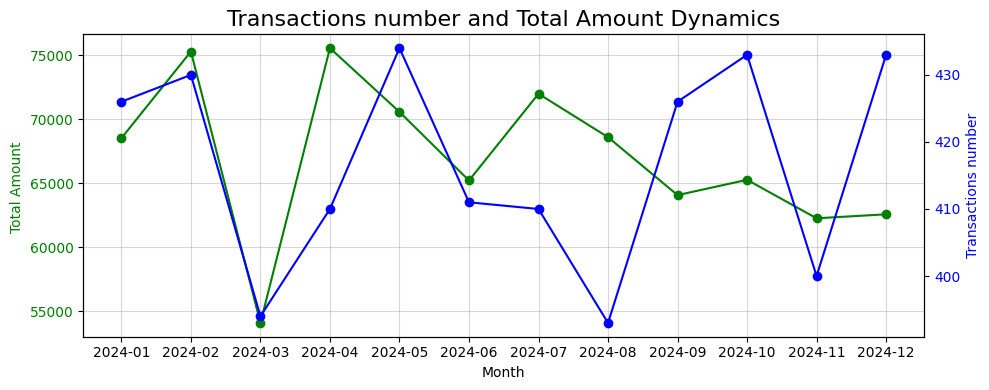

In [16]:
# data visualization - task1
fig, ax1 = plt.subplots(figsize=(10, 4))

# First axis: total amount
ax1.set_title('Transactions number and Total Amount Dynamics', fontsize=16)
ax1.set_xlabel('Month', fontsize=10)
ax1.set_ylabel('Total Amount ', fontsize=10, color='green')
ax1.plot(df1['month'], df1['total_amount'], label='Total Amount', marker='o', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(alpha=0.5)

# Second axis: transactions number
ax2 = ax1.twinx()
ax2.set_ylabel('Transactions number', fontsize=10, color='blue')
ax2.plot(df1['month'], df1['num_transactions'], label='Transactions number', marker='o', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# X-axis settings
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

As a result, we can observe the dynamics of revenue amounts by month and the number of transactions on a single graph, allowing us to draw conclusions and uncover insights.

In [17]:
# checking task 2
df2

,month,moving_average_sales
0,2024-01,68525.230000000000
1,2024-02,71916.690000000000
2,2024-03,65965.460000000000
3,2024-04,68316.140000000000
4,2024-05,66740.446666666667
5,2024-06,70457.340000000000
6,2024-07,69265.283333333333
7,2024-08,68605.960000000000
8,2024-09,68224.983333333333
9,2024-10,65980.333333333333


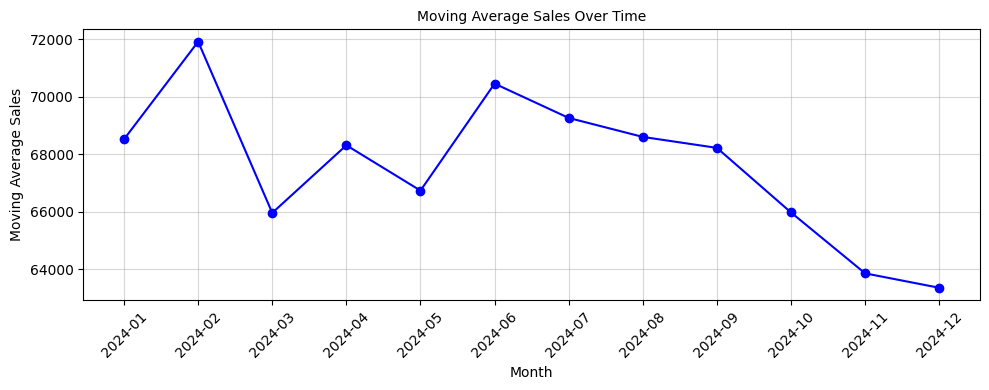

In [18]:
# data visualization - task2
plt.figure(figsize=(10, 4))
plt.plot(df2['month'], df2['moving_average_sales'], label='Moving Average Sales', marker='o', color='blue')

# Title and labels
plt.title('Moving Average Sales Over Time', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Moving Average Sales', fontsize=10)

# X-axis settings
plt.xticks(rotation=45)

# Show grid
plt.grid(alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

This graph will allow us to observe the trend of the moving average of the sales amount over the months.

In conclusion of this task, I would like to say the following:

Depending on the volume of data, structure, format, business logic, and available resources, different data architectures can be built. This is a highly flexible process, influenced by many variables and factors, including the specific needs of the business.

These scripts, with minor modifications, can easily be integrated into Airflow to automate the loading, transformation, and updating of data for dashboards.